# House Price Range Classification using KNN

This notebook implements a K-Nearest Neighbors (KNN) classifier to predict house price categories based on property features. The workflow includes data cleaning, outlier treatment, feature scaling, and hyperparameter optimization for K.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import ML_Modules
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

### 1. Load the Dataset

In [2]:
# Load the specified dataset
df = pd.read_excel('ML470_S9_KCHouse_Data_Practice.xlsx')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (21613, 11)


,id,date,price,bedrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1180,5650,1.0,7,1180,1340,5650
1,6414100192,20141209T000000,538000,3,2570,7242,2.0,7,2170,1690,7639
2,5631500400,20150225T000000,180000,2,770,10000,1.0,6,770,2720,8062
3,2487200875,20141209T000000,604000,4,1960,5000,1.0,7,1050,1360,5000
4,1954400510,20150218T000000,510000,3,1680,8080,1.0,8,1680,1800,7503


### 2. Data Preparation and Transformation

*   Drop unnecessary columns.
*   Categorize prices into quartiles (Low, Mid, Upper-Mid, High).
*   Encode target labels numerically.

In [3]:
# Drop ID and Date as they don't contribute to the model
df.drop(['id', 'date'], axis=1, inplace=True)

# Categorize house prices into 4 ranges (quartiles)
df['price_range'] = pd.qcut(df['price'], q=4, labels=['Low', 'Mid', 'Upper-Mid', 'High'])

# Encode the target labels
le = LabelEncoder()
df['price_range_encoded'] = le.fit_transform(df['price_range'])

print("Target Categories:", df['price_range'].unique().tolist())
df[['price', 'price_range', 'price_range_encoded']].head()

Target Categories: ['Low', 'Upper-Mid', 'High', 'Mid']


,price,price_range,price_range_encoded
0,221900,Low,1
1,538000,Upper-Mid,3
2,180000,Low,1
3,604000,Upper-Mid,3
4,510000,Upper-Mid,3


### 3. Outlier Treatment and Multicollinearity Resolution

*   Apply Winsorization via `ML_Modules` to handle extreme values.
*   Remove highly correlated features (`sqft_living`, `sqft_lot`) to reduce redundancy.

In [4]:
# Treat outliers in numerical columns
df_numeric = df.drop(['price_range'], axis=1)
df_treated = ML_Modules.treat_outliers(df_numeric)

# Resolve Multicollinearity: Drop original price and highly correlated square footage features
df_final = df_treated.drop(['price', 'sqft_living', 'sqft_lot'], axis=1)

print("Final Features:", df_final.drop('price_range_encoded', axis=1).columns.tolist())
df_final.head()

Final Features: ['bedrooms', 'floors', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15']


,bedrooms,floors,grade,sqft_above,sqft_living15,sqft_lot15,price_range_encoded
0,3.0,1.0,7.0,1180.0,1340.0,5650.0,1.0
1,3.0,2.0,7.0,2170.0,1690.0,7639.0,3.0
2,2.0,1.0,6.0,770.0,2720.0,8062.0,1.0
3,4.0,1.0,7.0,1050.0,1360.0,5000.0,3.0
4,3.0,1.0,8.0,1680.0,1800.0,7503.0,3.0


### 4. Scaling and Splitting Data

In [9]:
X = df_final.drop('price_range_encoded', axis=1)
y = df_final['price_range_encoded']

# Standardize the features
X_scaled = ML_Modules.data_scale(X)

# Split into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 15129 samples
Testing set: 6484 samples


### 5. Identify Optimal K Value

We evaluate the error rate for K values ranging from 1 to 40.

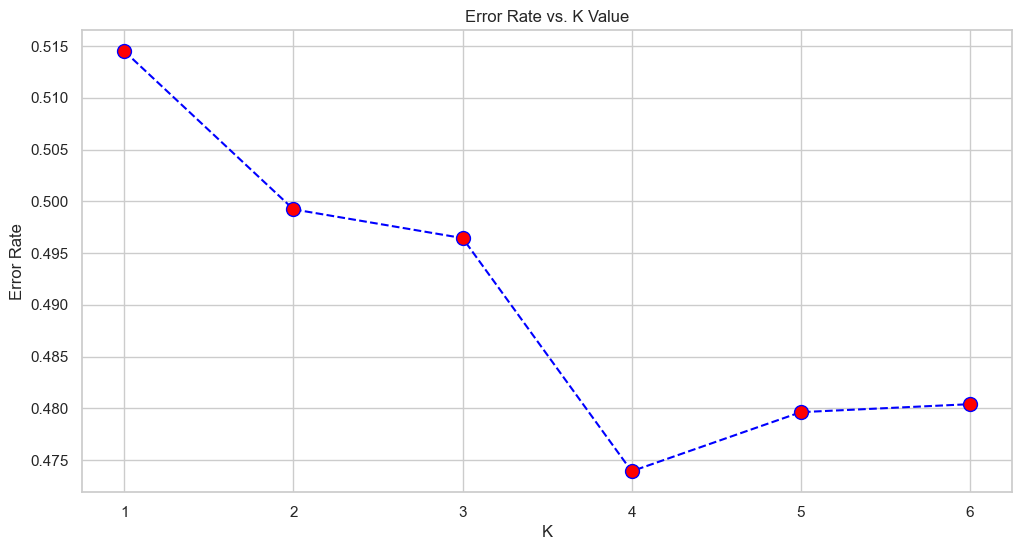

Minimum Error Rate found at K = 4


In [11]:
error_rate = []
for i in range(1, 7):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(1 - accuracy_score(y_test, pred_i))

# Plotting the error rate
plt.figure(figsize=(12, 6))
plt.plot(range(1, 7), error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

best_k = error_rate.index(min(error_rate)) + 1
print(f"Minimum Error Rate found at K = {best_k}")

### 6. Final Model and Evaluation

In [7]:
# Build and train the final model
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

# Predictions
y_pred = knn_final.predict(X_test)
y_prob = knn_final.predict_proba(X_test)

# Metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
}

print("--- Model Performance Metrics ---")
for metric, value in metrics.items():
    print(f"{metric:10}: {value:.4f}")

--- Model Performance Metrics ---
Accuracy  : 0.5407
Precision : 0.5368
Recall    : 0.5407
F1-Score  : 0.5362
ROC-AUC   : 0.7944
